# Data Source and Preparation

The Add-In was developed using Visual Studio 2019.  Please see [Microsoft's Quick Start tutorial on creating an Add-In for MS Word](https://docs.microsoft.com/en-us/office/dev/add-ins/quickstarts/word-quickstart?tabs=visualstudio).

Data was downloaded from TaPaCo: A Corpus of Sentential Paraphrases for 73 Languages (https://zenodo.org/record/3707949). This dataset is licensed under Creative Commons Attribution 2.0 Generic. The first stage of data prep was in Excel.  Unused data was removed retaining only English training data.  Data was saved in a format to be parsed by a [B4J](https://www.b4x.com/b4j.html) program that was used to reformat the data to create prompts consumable by the OpenAI fine-tuning system.

Here is an example line:
{"prompt": "I'm eating cheese. ->","completion": "I'm having some cheese.\n END"}

The B4J app has a function to compare the similarity between sentences in the number of words that are the same.  For this training, the similarity ratio was set to .7.  The reason for this filter was to avoid training the system to provide sentences that just move words around or change the tense of a word.

Note: you may not be able to run all of these commands from Jupyter Notebook, because it is not possible to answer prompts.

Let's first run the data preparation tool.

In [6]:
!openai tools fine_tunes.prepare_data -f output_prepared_10_16_21_filtered.jsonl

Analyzing...

- Your file contains 66281 prompt-completion pairs
- All prompts end with suffix `\n ->`
- All completions end with suffix `\n END`

No remediations found.

You can use your file for fine-tuning:
> openai api fine_tunes.create -t "output_prepared_10_16_21_filtered.jsonl" --batch_size 1

After you’ve fine-tuned a model, remember that your prompt has to end with the indicator string `\n ->` for the model to start generating completions, rather than continuing with the prompt. Make sure to include `stop=["\n END"]` so that the generated texts ends at the expected place.
Once your model starts training, it'll approximately take 15.21 hours to train a `curie` model, and less for `ada` and `babbage`. Queue will approximately take half an hour per job ahead of you.


After trying to run the fine tuning, an error was received because of special characters that were not escaped.  OpenAI's natural language to python (Codex) was used to generate Python code to fix the escaping.  The code produced by Codex did require some modification, but was quite useful.

In [ ]:
#"""
#1. escape all special characters in the json strings in the file output.jsonl
#"""

import json
import re

def escape_json_string(json_string):
#    """
#    escape all special characters in the json strings in the file output.jsonl
#    """
    json_string = json_string.replace('\\', '\\\\')
    json_string = json_string.replace('"', '\\"')
    json_string = json_string.replace('\n', '\\n')
    json_string = json_string.replace('\t', '\\t')
    json_string = json_string.replace('\b', '\\b')
    json_string = json_string.replace('\f', '\\f')
    return json_string

def escape_json_file(input_file, output_file):
#    """
#    escape all special characters in the json strings in the file output.jsonl
#    """
    with open(input_file, 'r') as f:
        with open(output_file, 'w') as fout:
            for line in f:
                fout.write(escape_json_string(line) + '\n')

if __name__ == '__main__':
    escape_json_file('prepocessed_10_16_21.txt', 'readytoprocess_10_16_21.txt')

Then the data was processed through the B4J program.  The resulting data was now processed by the data prep tool.

In [ ]:
!openai api fine_tunes.create -t "output_prepared_10_6_21_filtered.jsonl" -m "curie"

The training now worked for the 66400 examples.

# Get our first completion

In [7]:
import openai

In [ ]:
promptText="Twice, he looked behind himself, fearing that someone might be following. ->"
numWords=promptText.count(" ")
openai.Completion.create(
    model="*********************REPLACE",
    max_tokens=numWords+5,
    n=2,
    temperature=0.7,
    stop="END",
    prompt=promptText)

The Add-In was completed and configured to provide 2 responses for the user.  See screenshot.

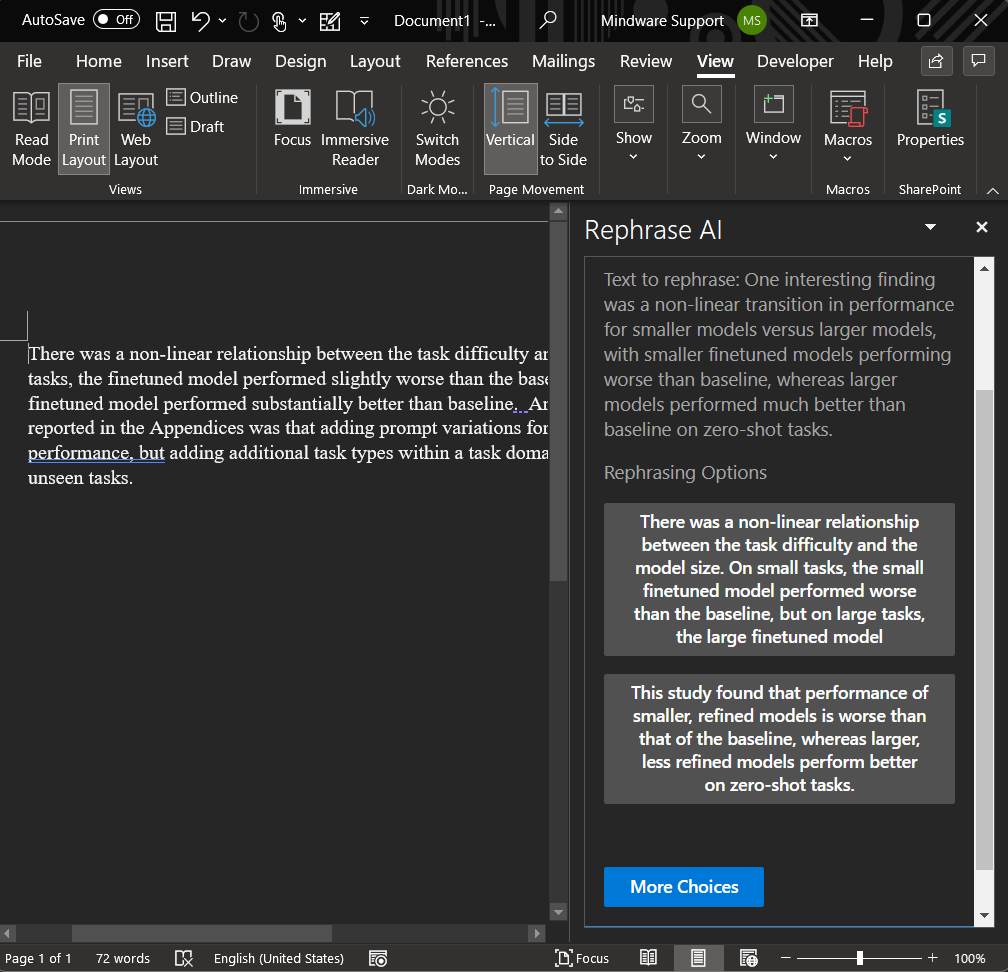

# Add API Key and Fine-Tuned Model Name to home.js
I added the OpenAI API Key and the ID for the fine-tuned Curie model to home.js.

# Fine-tuning Experiments
Finetuned the Ada model as it is the most affordable.  I maximized the fine tuning data using as close to the 3,000,000 token limit as possible.  I took a random sample from a combination of the previous data above along with two other rephrasing datasets (MRPC, QQP).  These datasets contained non-matching examples to be used for paraphrase detection.  I filtered out the non-maching sentences. This combined data caused the training dataset to be rejected as it had 6.5M+ tokens.  I wrote a B4J procedure to randomly sample the data down to a little under the 3M token limit.  The training completed with the ada dataset.  I used the following command for training.

In [ ]:
!openai api fine_tunes.create -t "output_10_16_21_sampled.jsonl" -m "ada" --batch_size 4

In [ ]:
import openai

In [ ]:
promptText="Twice, he looked behind himself, fearing that someone might be following. ->"
numWords=promptText.count(" ")
openai.Completion.create(
    model="******REPLACE***********",
    max_tokens=numWords+5,
    n=2,
    temperature=0.9,
    stop="END",
    prompt=promptText)

The Ada results are not good.  I also noticed an inordinate about of inappropriate suicide related questions in the dataset.  I downloaded a list of profanity words by Google and altered a B4J program to filter out sentences that contain these words.  It removed 8007 lines.  I used the resulting dataset to finetune a Babbage model.  I removed the batch size=4 element.

In [ ]:
!openai api fine_tunes.create -t "output_10_16_21_filtered.jsonl" -m "babbage"

In [ ]:
!openai api fine_tunes.list

In [ ]:
promptText="Twice, he looked behind himself, fearing that someone might be following. ->"
numWords=promptText.count(" ")
openai.Completion.create(
    model="******REPLACE**********",
    max_tokens=numWords+5,
    n=2,
    temperature=0.6,
    stop="END",
    prompt=promptText)

# Evaluation of Results
The Babbage finetuned model works quite well.  Maybe it is even better than the Curie, which is not trained on nearly as many examples.  I integrated the model id into the Word Add-In and experimented with a few sentences (comparing Curie to Babbage).  I was generally more satisfied with the Babbage model.  The Curie model could obviously be made better with training on the same data, but the Babbage model is more affordable, faster, and uses less energy.